In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import lightgbm as lgb
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error
from ngboost import NGBRegressor
from ngboost.distns import Normal
train_df = pd.read_csv("/Users/anushkaroy17/CBAM-ResGANet/kaggle_data/train.csv")
test_df = pd.read_csv("//Users/anushkaroy17/CBAM-ResGANet/kaggle_data/test.csv")

In [29]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00


In [4]:
print("Train shape :", train_df.shape)
print("Test shape : ",test_df.shape)

Train shape : (2177, 2)
Test shape :  (545, 1)


In [13]:
npy_dir = "/Users/anushkaroy17/CBAM-ResGANet/kaggle_data/ot/ot"
sample_id = train_df['id'].iloc[120]
sample_path = os.path.join(npy_dir,sample_id)
data = np.load(sample_path)
print("Shape of the sample is : ",data.shape)

Shape of the sample is :  (128, 128, 125)


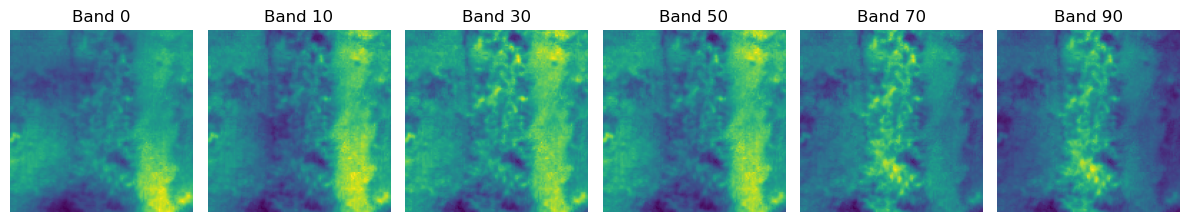

In [14]:
plt.figure(figsize=(12, 4))
for i, band in enumerate([0, 10, 30, 50, 70, 90]):
    plt.subplot(1, 6, i+1)
    plt.imshow(data[:, :, band], cmap='viridis')
    plt.title(f'Band {band}')
    plt.axis('off')
plt.tight_layout()
plt.show()

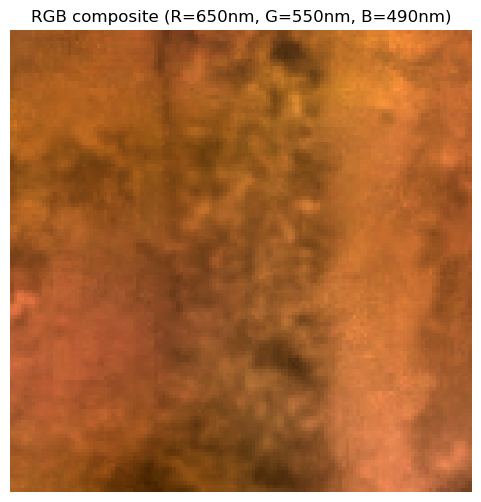

In [16]:
import numpy as np
import matplotlib.pyplot as plt
b_blue  = 0  
b_green = 15  
b_red   = 40  

rgb = np.stack([data[:, :, b_red],
                data[:, :, b_green],
                data[:, :, b_blue]], axis=-1).astype(np.float32)
rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb) + 1e-8)
rgb = np.clip(rgb, 0, 1)

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.axis('off')
plt.title('RGB composite (R=650nm, G=550nm, B=490nm)')
plt.show()


In [5]:
BASE_DIR    = "/Users/anushkaroy17/CBAM-ResGANet/kaggle_data/"
NPY_DIR     = os.path.join(BASE_DIR, "ot/ot")
TRAIN_CSV   = os.path.join(BASE_DIR, "train.csv")
TEST_CSV    = os.path.join(BASE_DIR, "test.csv")

IMG_SHAPE   = (128, 128, 125)
TARGET_SIZE = np.prod(IMG_SHAPE)

In [8]:


# xgboost
def load_and_flatten(path):

    try:
        arr = np.load(path)
        flat = arr.ravel()
    except Exception:
        flat = np.fromfile(path, dtype=np.float32)

    # pad/truncate to TARGET_SIZE
    if flat.size < TARGET_SIZE:
        if flat.size == 0:
            flat = np.zeros(TARGET_SIZE, dtype=np.float32)
        else:
            pad_vals = np.full(TARGET_SIZE - flat.size, flat[-1], dtype=np.float32)
            flat = np.concatenate([flat, pad_vals])
    else:
        flat = flat[:TARGET_SIZE]

    return flat


def extract_features(df):

    features = []
    for fn in df['id']:
        path = os.path.join(NPY_DIR, fn)
        flat = load_and_flatten(path)
        cube = flat.reshape(IMG_SHAPE)
        band_means = cube.mean(axis=(0, 1))
        features.append(band_means)
    return np.vstack(features)

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Extracting features for training set.")
X = extract_features(train_df)    # shape (n_train, 125)
y = train_df['label'].values

print("Extracting features for test set.")
X_test = extract_features(test_df) # shape (n_test, 125)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

xgb_model = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist', 
    eval_metric='mae'      
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)
y_pred_val = xgb_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_pred_val)
print(f"Validation MAE: {val_mae:.4f}")



Extracting features for training set.
Extracting features for test set.
[0]	validation_0-mae:25.25958	validation_1-mae:24.46038
[1]	validation_0-mae:24.96379	validation_1-mae:24.36655
[2]	validation_0-mae:24.55524	validation_1-mae:24.37903
[3]	validation_0-mae:24.35145	validation_1-mae:24.38088
[4]	validation_0-mae:24.03297	validation_1-mae:24.40426
[5]	validation_0-mae:23.79105	validation_1-mae:24.49512
[6]	validation_0-mae:23.44533	validation_1-mae:24.53833
[7]	validation_0-mae:23.23029	validation_1-mae:24.56930
[8]	validation_0-mae:23.15703	validation_1-mae:24.57465
[9]	validation_0-mae:22.95068	validation_1-mae:24.59874
[10]	validation_0-mae:22.79951	validation_1-mae:24.58757
[11]	validation_0-mae:22.63393	validation_1-mae:24.51549
[12]	validation_0-mae:22.45433	validation_1-mae:24.42596
[13]	validation_0-mae:22.21297	validation_1-mae:24.40660
[14]	validation_0-mae:22.03276	validation_1-mae:24.45296
[15]	validation_0-mae:21.80096	validation_1-mae:24.59982
[16]	validation_0-mae:21.5

In [6]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels)
        self.bn1 = nn.BatchNorm1d(channels)
        self.fc2 = nn.Linear(channels, channels)
        self.bn2 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        return self.relu(out + residual)
class GlobalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(channels, channels // 2),
            nn.ReLU(inplace=True),
            nn.Linear(channels // 2, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        weights = self.attn(x)
        return x * weights

class ResGANet(nn.Module):
    def __init__(self, input_dim=125, hidden_dim=256, num_blocks=3):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim) for _ in range(num_blocks)]
        )
        self.global_attn = GlobalAttention(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)  # regression

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = self.res_blocks(x)
        x = self.global_attn(x)
        return self.output_layer(x)

def train_resganet(X_train, y_train, X_val, y_val,
                   input_dim=125, hidden_dim=256, num_blocks=2,
                   batch_size=64, epochs=20, lr=1e-6, device="cpu"):

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
    val_dataset   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                  torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ResGANet(input_dim=input_dim, hidden_dim=hidden_dim, num_blocks=num_blocks).to(device)
    criterion = nn.L1Loss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_preds.append(preds.cpu().numpy())
                val_targets.append(yb.cpu().numpy())
        val_preds = np.vstack(val_preds)
        val_targets = np.vstack(val_targets)
        val_mae = mean_absolute_error(val_targets, val_preds)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f}", flush = 'True')

    return model

resganet_model = train_resganet(X_train, y_train, X_val, y_val, device=device)


Epoch 1/20 | Train Loss: 107.5615 | Val MAE: 121560809861213493133312.0000
Epoch 2/20 | Train Loss: 68.9806 | Val MAE: 121204512080293703712768.0000
Epoch 3/20 | Train Loss: 58.7358 | Val MAE: 121435564755576319639552.0000
Epoch 4/20 | Train Loss: 53.3038 | Val MAE: 121766723443376126951424.0000
Epoch 5/20 | Train Loss: 50.0765 | Val MAE: 114410174516859714404352.0000
Epoch 6/20 | Train Loss: 46.2890 | Val MAE: 113937584786361964036096.0000
Epoch 7/20 | Train Loss: 42.2008 | Val MAE: 114091788037603129819136.0000
Epoch 8/20 | Train Loss: 36.0393 | Val MAE: 114012236453785257377792.0000
Epoch 9/20 | Train Loss: 32.4528 | Val MAE: 101319552472782638940160.0000
Epoch 10/20 | Train Loss: 31.4469 | Val MAE: 100953040527907973234688.0000
Epoch 11/20 | Train Loss: 30.8366 | Val MAE: 100530864091639008198656.0000
Epoch 12/20 | Train Loss: 30.5149 | Val MAE: 100031234748978525372416.0000
Epoch 13/20 | Train Loss: 30.2896 | Val MAE: 99454035406336213123072.0000
Epoch 14/20 | Train Loss: 30.0948 

In [14]:

# resganet + cbam
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels)
        self.bn1 = nn.BatchNorm1d(channels)
        self.fc2 = nn.Linear(channels, channels)
        self.bn2 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        return self.relu(out + residual)

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(torch.mean(x, dim=0, keepdim=True))
        max_out = self.fc(torch.max(x, dim=0, keepdim=True)[0])
        out = avg_out + max_out
        return x * self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // 2, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // 2, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        attn = self.fc(x)
        return x * attn


class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention(channels)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x


class ResGANetCBAM(nn.Module):
    def __init__(self, input_dim=125, hidden_dim=64, num_blocks=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim) for _ in range(num_blocks)]
        )
        self.cbam = CBAM(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)  # regression

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = self.res_blocks(x)
        x = self.cbam(x)
        return self.output_layer(x)


def train_resganet_cbam(X_train, y_train, X_val, y_val,
                        input_dim=125, hidden_dim=256, num_blocks=3,
                        batch_size=64, epochs=50, lr=1e-3, device="cpu"):

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
    val_dataset   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                  torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ResGANetCBAM(input_dim=input_dim, hidden_dim=hidden_dim, num_blocks=num_blocks).to(device)
    criterion = nn.L1Loss()  # MAE
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_preds.append(preds.cpu().numpy())
                val_targets.append(yb.cpu().numpy())
        val_preds = np.vstack(val_preds)
        val_targets = np.vstack(val_targets)
        val_mae = mean_absolute_error(val_targets, val_preds)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val MAE: {val_mae:.4f}")

    return model


device = "cuda" if torch.cuda.is_available() else "cpu"
resganet_cbam_model = train_resganet_cbam(X_train, y_train, X_val, y_val, device=device)


Epoch 1/50 | Train Loss: 76.2705 | Val MAE: 356296880199863946444800.0000
Epoch 2/50 | Train Loss: 31.1951 | Val MAE: 449863377827737219629056.0000
Epoch 3/50 | Train Loss: 27.6794 | Val MAE: 676759014481508064821248.0000
Epoch 4/50 | Train Loss: 29.3724 | Val MAE: 898098686375781495472128.0000
Epoch 5/50 | Train Loss: 28.6363 | Val MAE: 1051997061936572805414912.0000
Epoch 6/50 | Train Loss: 27.7991 | Val MAE: 1360411346639060467712000.0000
Epoch 7/50 | Train Loss: 27.1553 | Val MAE: 1458104438562297797935104.0000
Epoch 8/50 | Train Loss: 27.9500 | Val MAE: 1541711567887812899373056.0000
Epoch 9/50 | Train Loss: 27.1551 | Val MAE: 1612059235219220805451776.0000
Epoch 10/50 | Train Loss: 27.1260 | Val MAE: 1651924090314387905052672.0000
Epoch 11/50 | Train Loss: 27.0063 | Val MAE: 1671809392195470649982976.0000
Epoch 12/50 | Train Loss: 27.5881 | Val MAE: 1723792749340748394004480.0000
Epoch 13/50 | Train Loss: 27.9982 | Val MAE: 1737880153090351381348352.0000
Epoch 14/50 | Train Loss:

In [24]:

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()  # flatten for LinearRegression
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train_scaled)

y_pred_val_scaled = lin_model.predict(X_val_scaled)
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled.reshape(-1, 1))

val_mae = mean_absolute_error(y_val, y_pred_val)
print(f"Validation MAE: {val_mae:.4f}")


Validation MAE: 577196279522957440581632.0000


In [ ]:

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
ngb_model = NGBRegressor(Dist=Normal, learning_rate=0.08, n_estimators=800, verbose=True)

ngb_model.fit(X_train_scaled, y_train)
y_pred_val = ngb_model.predict(X_val_scaled)

val_mae = mean_absolute_error(y_val, y_pred_val)
print(f"Validation MAE: {val_mae:.4f}")


[iter 0] loss=4.8046 val_loss=0.0000 scale=1.0000 norm=25.6741
[iter 100] loss=4.5599 val_loss=0.0000 scale=1.0000 norm=21.2067
[iter 200] loss=4.3647 val_loss=0.0000 scale=1.0000 norm=18.1818
[iter 300] loss=4.2037 val_loss=0.0000 scale=1.0000 norm=16.0283
[iter 400] loss=4.0629 val_loss=0.0000 scale=0.5000 norm=7.1986
[iter 500] loss=4.0357 val_loss=0.0000 scale=0.0002 norm=0.0034
[iter 600] loss=4.0348 val_loss=0.0000 scale=0.0002 norm=0.0034
[iter 700] loss=4.0348 val_loss=0.0000 scale=0.0002 norm=0.0034
Validation MAE: 25.2064


In [33]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

train_data = lgb.Dataset(X_train_scaled, label=y_train)
val_data = lgb.Dataset(X_val_scaled, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt', 
    'learning_rate': 0.08,
    'num_leaves': 31,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 42
}

lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=800,
    valid_sets=[train_data, val_data]
    # verbose_eval=50
)

y_pred_val = lgb_model.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_pred_val)
print(f"Validation MAE: {val_mae:.4f}")


Validation MAE: 26.1511


In [34]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

train_data = lgb.Dataset(X_train_scaled, label=y_train)
val_data = lgb.Dataset(X_val_scaled, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'dart', 
    'learning_rate': 0.08,
    'num_leaves': 31,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 42
}

lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=800,
    valid_sets=[train_data, val_data]
    # verbose_eval=50
)

y_pred_val = lgb_model.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_pred_val)
print(f"Validation MAE: {val_mae:.4f}")


Validation MAE: 25.5456
